# ENSO_diversity: Zonal Location of Maximum SST Anomalies in the Equatorial Pacific  

Computes the interquartile range (IQR) of the zonal location distribution of the maximum (and minimum) sea surface temperature anomalies (SSTA) in the equatorial Pacific, averaged meridionally over 5°S–5°N. This metric quantifies the diversity in the zonal location of the maximum (during El Niño) and minimum (during La Niña) SST anomalies during boreal winter. The analysis uses December values smoothed with a 5-month triangular-weighted moving average to reduce seasonal variability.  

## Datasets Used for Diversity Comparison  

The following reference datasets are used to evaluate the spatial diversity of maximum SST anomalies in model simulations:  

- **TropFlux (1979–2018)**: The primary dataset for comparison, offering tropical climate variability data, including SST anomalies and fluxes over the tropical oceans.  

Additional datasets include:  
- **20CRv2 (1871–2012)**: A historical atmospheric reanalysis dataset that provides surface pressure-based global atmospheric data over more than a century.  
- **ERA-Interim (1979–2018)**: A reanalysis dataset from the ECMWF, providing high-resolution atmospheric and surface data using modern assimilation techniques.  
- **ERSSTv5 (1854–2018)**: A dataset optimised for reconstructing global SST anomalies and capturing climate variability, including ENSO.  
- **HadISST (1870–2018)**: A dataset providing global SST reconstructions using in-situ measurements and satellite observations.  
- **NCEP2 (1979–2018)**: A second-generation reanalysis from NCEP that improves upon earlier reanalysis products and offers global atmospheric and surface data.   

## Dask Cluster 

Start a cluster with multiple cores 

In [1]:
from dask.distributed import Client, progress
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 12,Total memory: 46.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46173,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 12
Started: Just now,Total memory: 46.00 GiB
Comm: tcp://127.0.0.1:41387,Total threads: 3
Dashboard: /proxy/33427/status,Memory: 11.50 GiB
Nanny: tcp://127.0.0.1:34553,


## Datasets

In [2]:
from esmvalcore.dataset import Dataset

### Datasets

In [21]:
model_datasets = {
"ACCESS-CM2": 
    Dataset(
    short_name='ts',
    project='CMIP6',
    mip="Amon",
    exp="historical",
    ensemble="r1i1p1f1",
    timerange="19000101/20190101",
    dataset="ACCESS-CM2",
    grid="gn"
)}

obs_datasets = {
"HadISST": 
    Dataset(
    short_name='ts',
    dataset='HadISST',
    mip="Amon",
    project='OBS',
    type='reanaly',
    tier=2),
# "ERSSTv5":
#     Dataset(
#     short_name='tos',
#     dataset='NOAA-ERSSTv5',
#     mip="Omon",
#     project='OBS6',
#     type='reanaly',
#     tier=2),
# "ERA-Interim": 
#     Dataset(
#     short_name='tos',
#     dataset='ERA-Interim',
#     mip="Omon",
#     project='OBS6',
#     type='reanaly',
#     timerange="19790101/20190101",
#     tier=3)
}

## Add Ancillary files


In [22]:
for name, dataset in model_datasets.items():
    dataset.add_supplementary(short_name='sftlf', mip="fx")
    dataset.add_supplementary(short_name="areacella", mip="fx")

In [23]:
model_datasets = {name: dataset.load() for name, dataset in model_datasets.items()}
obs_datasets = {name: dataset.load() for name, dataset in obs_datasets.items()}

(for file /g/data/fs38/publications/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r1i1p1f1/fx/sftlf/gn/v20191108/sftlf_fx_ACCESS-CM2_historical_r1i1p1f1_gn.nc)


In [6]:
from esmvalcore.preprocessor import detrend  # Remove trends from the data
from esmvalcore.preprocessor import meridional_statistics  # Calculate statistics along meridional direction
from esmvalcore.preprocessor import zonal_statistics  # Calculate statistics along zonal direction
from esmvalcore.preprocessor import area_statistics  # Compute area-based statistics
from esmvalcore.preprocessor import regrid  # Regrid data using ESMF bilinear method
from esmvalcore.preprocessor import mask_landsea  # Mask land or sea regions
from esmvalcore.preprocessor import anomalies  # Compute anomalies in the data
from esmvalcore.preprocessor import extract_month  # Extract specific month from the data
from esmvalcore.preprocessor import extract_time
from esmvalcore.preprocessor import mask_inside_range  # Mask values inside a specified range
from esmvalcore.preprocessor import mask_above_threshold  # Mask values above a specified threshold
from esmvalcore.preprocessor import mask_below_threshold  # Mask values below a specified threshold
from esmvalcore.preprocessor import extract_region  # Extract a specific geographical region (e.g., Equatorial Pacific)
from esmvalcore.preprocessor import climate_statistics  # Compute month mean and standard deviation
from esmvalcore.preprocessor import rolling_window_statistics  # Apply rolling window statistics

import iris
import numpy as np
import iris.quickplot as qplt
import matplotlib.pyplot as plt
import iris.plot as iplt
import matplotlib.colors as mcolors
import cartopy.feature as cfeature
import cartopy.crs as ccrs

In [7]:
def nino3_4ssta(cube):
    cube = extract_region(cube, 190, 240, -5, 5) #
    cube = extract_time(cube, start_year=1900, start_month=1, start_day=1, end_year=2014, end_month=12, end_day=31)    
    cube = regrid(cube, target_grid="1x1", scheme="linear")   
    # triangle weighted- double smoothed
    cube = rolling_window_statistics(cube, coordinate='time', operator='mean', window_length=5)
    cube = rolling_window_statistics(cube, coordinate='time', operator='mean', window_length=5)
    cube = area_statistics(cube, 'mean')
    cube = extract_month(cube, 12)
    cube = anomalies(cube, period='monthly', standardize=True)  #normalise
    return cube

def eq_ssta(cube):
    cube = extract_region(cube, 150, 270, -5, 5)
    cube = extract_time(cube, start_year=1900, start_month=1, start_day=1, end_year=2014, end_month=12, end_day=31)    
    # season cycle? detrend? #convert units
    cube = rolling_window_statistics(cube, coordinate='time', operator='mean', window_length=5)
    cube = rolling_window_statistics(cube, coordinate='time', operator='mean', window_length=5)
    cube = extract_month(cube, 12)
    cube = anomalies(cube, period='monthly')
    cube = regrid(cube, target_grid="1x1", scheme="linear") 
    cube = meridional_statistics(cube, 'mean') #
     # weighted running average 5-degree
    cube = rolling_window_statistics(cube, coordinate='longitude', operator='mean', window_length=5)
    cube = rolling_window_statistics(cube, coordinate='longitude', operator='mean', window_length=5)
    return cube

def enso_events(cube):
    mean, std = cube.data.mean(), cube.data.std() #normalised, use 0.75
    # range1, range2 = mean-0.75*std, mean + 0.75*std 
    a_events = mask_to_years(mask_above_threshold(cube.copy(), -0.75*std))
    o_events = mask_to_years(mask_below_threshold(cube.copy(), 0.75*std))
    return {'nina':a_events, 'nino':o_events}

def mask_to_years(events):
    # build time with mask
    maskedTime = np.ma.masked_array(events.coord('time').points, mask=events.data.mask)
    # print(f'events cube shape: {events.shape}')
    # return years
    return [events.coord('time').units.num2date(time).year for time in maskedTime.compressed()]

# Diversity - get zonal location of max and min
def diversity(ssta_cube, events_dict): #2 masks/events list
    # each enso year, max/min SSTA, get longitude
    res_lon = {}
    for enso, events in events_dict.items():
        year_enso = iris.Constraint(time=lambda cell: cell.point.year in events)
        cube = ssta_cube.extract(year_enso)
        if enso == 'nina':
            cube = cube * -1
        #iterate through cube, each time get max/min value and return lon
        loc_ls = []
        for yr_slice in cube.slices(['longitude']):

            indx = np.argmax(yr_slice.data) # if nina multiply by -1 or min
            loc_ls.append(cube.coord('longitude').points[indx])

        res_lon[enso] = loc_ls
        
    res_lon['enso'] = res_lon['nino'] + res_lon['nina']
    return res_lon # return data to plot 

# IQR and abs((model-ref)/ref)*100
def iqr(data):
    #calculate interquartile range 
    q3, q1 = np.percentile(data, [75 ,25])
    iqr = q3 - q1
    return iqr
    
def compute(obs_iqr, mod_iqr):
    return abs((mod_iqr-obs_iqr)/obs_iqr)*100

def preproc(dataset):
    nino_res = nino3_4ssta(dataset)
    events = enso_events(nino_res)
    eq_res = eq_ssta(dataset)
    return eq_res, events


In [24]:
model_datasets_prep = {name: preproc(dataset) for name, dataset in model_datasets.items()}

model_datasets_res = {name: diversity(*preprocs) for name, preprocs in model_datasets_prep.items()}

/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/cube.py:4620: IrisIgnoringBoundsWarning: The bounds of coordinate 'time' were ignored in the rolling window operation.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/numpy/ma/core.py:5417: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = super().var(axis=axis, dtype=dtype, out=out, ddof=ddof,
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/cube.py:4620: IrisIgnoringBoundsWarning: The bounds of coordinate 'time' were ignored in the rolling window operation.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/cube.py:4067: IrisUserWarning: Collapsing spatial co

In [25]:
obs_datasets_prep = {name: preproc(dataset) for name, dataset in obs_datasets.items()}

/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/cube.py:4620: IrisIgnoringBoundsWarning: The bounds of coordinate 'time' were ignored in the rolling window operation.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/numpy/ma/core.py:5417: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = super().var(axis=axis, dtype=dtype, out=out, ddof=ddof,
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/cube.py:4620: IrisIgnoringBoundsWarning: The bounds of coordinate 'time' were ignored in the rolling window operation.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/cube.py:4067: IrisUserWarning: Collapsing spatial co

In [26]:
obs_datasets_res = {name: diversity(*preprocs) for name, preprocs in obs_datasets_prep.items()}

metric = [iqr(model_datasets_res["ACCESS-CM2"]['enso']), 
          iqr(obs_datasets_res["HadISST"]['enso'])]
print('metric: ', compute(metric[1],metric[0]))

metric:  58.69565217391305


## Diagnostic Level 1

The first level shows the diagnostic used to compute the metric and highlight the difference between the model and the reference.

Text(0.75, 0.8, '* observation')

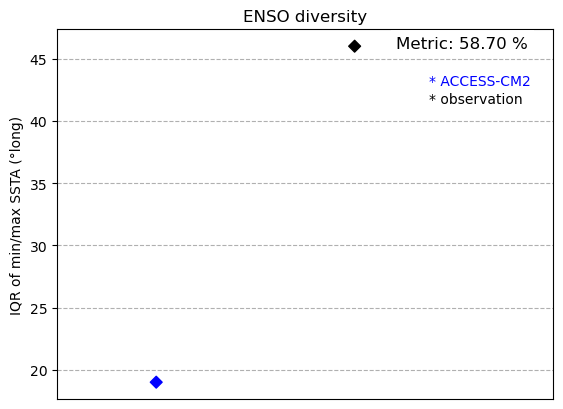

In [27]:
plt.scatter(range(len(metric)), metric, c=['blue','black'], marker='D')

plt.xlim(-0.5,2)#range(-1,3,1)) #['model','obs']
plt.xticks([])

plt.ylabel('IQR of min/max SSTA (°long)')
plt.grid(linestyle='--', axis='y')
plt.title('ENSO diversity')

metricval = compute(metric[1],metric[0])
plt.text(0.95, 0.95, f'Metric: {metricval:.2f} %', fontsize=12, ha='right', transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

plt.text(0.75,0.85, '* ACCESS-CM2', color='blue',transform=plt.gca().transAxes)
plt.text(0.75,0.8, '* observation', color='black',transform=plt.gca().transAxes)
# plt.legend(loc='lower right')

**Figure 1**: Width of the zonal location of maximum (minimum) SSTA during all El Niño (La Niña) events, illustrating the "diversity" of ENSO events. The model typically shows a smaller zonal width compared to the reference. The black markers represent the reference data, while the blue markers represent the model output. The derived metric is the absolute relative difference, calculated as: \( \text{abs}((\text{model} - \text{ref}) / \text{ref}) \times 100 \).


## Diagnostic Level 2

The second level shows the distribution of zonal location of the maximum SSTA during all ENSO events, La Niña events, El Niño events: the ENSO diversity.

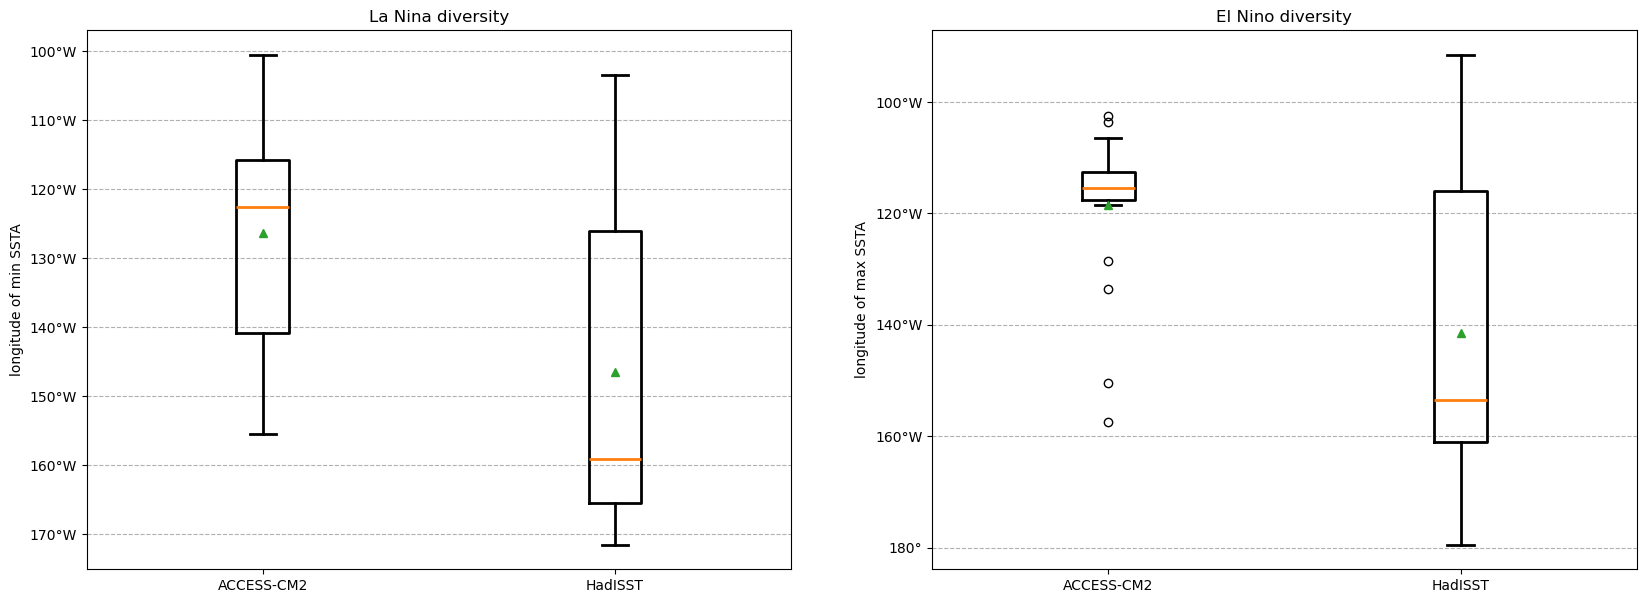

In [28]:
def format_longitude(x, pos):
    if x > 180:
        return f'{int(360 - x)}°W'
    elif x == 180:
        return f'{int(x)}°'
    else:
        return f'{int(x)}°E'

ds_labels = ['ACCESS-CM2','HadISST']
fig = plt.figure(figsize=(20, 7))
nina = [model_datasets_res["ACCESS-CM2"]['nina'], obs_datasets_res["HadISST"]['nina']] # subplots for nina and nino
nino = [model_datasets_res["ACCESS-CM2"]['nino'], obs_datasets_res["HadISST"]['nino']]
#another plot for enso = [process[ds]['enso'] for ds in process.keys()]

ax1 = plt.subplot(121)
bplt = ax1.boxplot(nina, labels=ds_labels, showmeans=True)
#check whiskers to 10th 90th percentile,, whis=(5,95) box-25th to 75th, diamond mean

for k in bplt.keys():
    plt.setp(bplt[k], linewidth=2)
# colours = ['blue','black']
# for k in ['boxes','whiskers','caps']:
#     for patch, colour in zip(bplt[k], ):
#         # patch.set_color(colour)
#         patch.set_linewidth(2)
#         if k == 'boxes':
#             patch.set_fill(False)
ax1.set_title('La Nina diversity')
plt.ylabel('longitude of min SSTA')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(format_longitude))
plt.grid(linestyle='--', axis='y')

ax1 = plt.subplot(122)
bplt = ax1.boxplot(nino, labels=ds_labels, showmeans=True) # whis=(10,90),
for k in bplt.keys():
    plt.setp(bplt[k], linewidth=2)
plt.title('El Nino diversity')
plt.ylabel('longitude of max SSTA')
plt.grid(linestyle='--', axis='y')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(format_longitude))

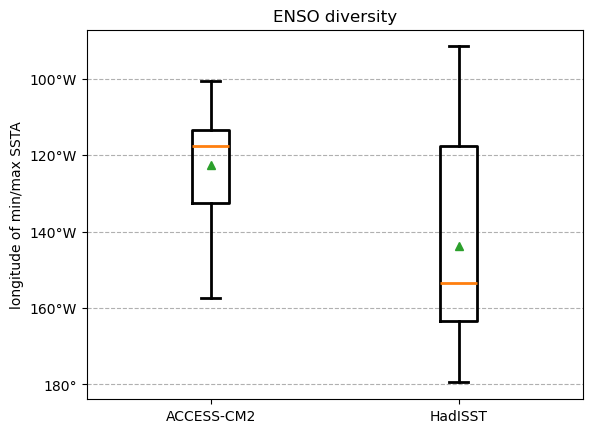

In [29]:
#plot for 
enso = [model_datasets_res["ACCESS-CM2"]['enso'], obs_datasets_res["HadISST"]['enso']]

bplt = plt.boxplot(enso, labels=ds_labels, showmeans=True) # whis=(10,90),
for k in bplt.keys():
    plt.setp(bplt[k], linewidth=2)
plt.title('ENSO diversity')
plt.ylabel('longitude of min/max SSTA')
plt.grid(linestyle='--', axis='y')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(format_longitude))

**Figure 2**: Distributions of the zonal location of the maximum SSTA during all ENSO events (top left), La Niña events (top right), and El Niño events (bottom left). The model typically shows a too wide distribution for La Niña events and too narrow for El Niño events. The distributions are also skewed in the wrong direction and shifted eastward for both types of events. The black and blue boxplots represent the reference and the model, respectively. Boxplots: whiskers extend to the 10th and 90th percentiles; boxes encompass the 25th and 75th percentiles; and a diamond marks the mean. La Niña (El Niño) events are defined when the December Niño3.4 SSTA (smoothed with a 5-month triangular-weighted moving average) is below -0.75 (above 0.75) standard deviation.
